In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [3]:

# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

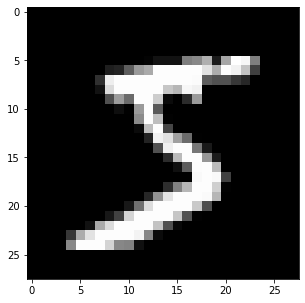

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
# define the NN architecture
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Conv - BatchNorm - Activation - DropOut - Pool
        # 28 -> 14
        self.encoder1 = torch.nn.Sequential(torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, dilation=1),
                                            torch.nn.BatchNorm2d(16),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # 14 -> 7
        self.encoder2 = torch.nn.Sequential(torch.nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, dilation=1),
                                            torch.nn.BatchNorm2d(64),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # 7 -> 3
        self.encoder3 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=2, dilation=1),
                                            torch.nn.BatchNorm2d(64),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size=3, stride=3))
        # 3 -> 1
        self.encoder4 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1),
                                            torch.nn.BatchNorm2d(64),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # ( 28 > 14 2*) ( 14 > 7 2*) (7+2 > 3) (3 > 1)
        ### decoder layers ###
        # 1 -> 3
        self.decoder4 = torch.nn.Sequential(torch.nn.ConvTranspose2d(64, 64, kernel_size=3, stride=3),
                                            torch.nn.BatchNorm2d(64),
                                            torch.nn.ReLU())

        # 3 -> 7
        self.decoder3 = torch.nn.Sequential(torch.nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),
                                            torch.nn.BatchNorm2d(64),
                                            torch.nn.ReLU())
        # 7 -> 14
        self.decoder2 = torch.nn.Sequential(torch.nn.ConvTranspose2d(64, 16, kernel_size=2, stride=2),
                                            torch.nn.BatchNorm2d(16),
                                            torch.nn.ReLU())
        # 14 -> 28
        self.decoder1 = torch.nn.Sequential(torch.nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
                                            torch.nn.Sigmoid())
        
        # now initialize weights, appicable to first index in sequential (conv_layer): [0]
        torch.nn.init.kaiming_uniform_(self.encoder1[0].weight)
        torch.nn.init.kaiming_uniform_(self.encoder2[0].weight)
        torch.nn.init.kaiming_uniform_(self.encoder3[0].weight)
        torch.nn.init.kaiming_uniform_(self.encoder4[0].weight)
        torch.nn.init.kaiming_uniform_(self.decoder4[0].weight)
        torch.nn.init.kaiming_uniform_(self.decoder3[0].weight)
        torch.nn.init.kaiming_uniform_(self.decoder2[0].weight)
        torch.nn.init.kaiming_uniform_(self.decoder1[0].weight)


    def forward(self, x):
        ### encode ###
        #print(x.shape)
        x = self.encoder1(x)
        #print(x.shape)
        x = self.encoder2(x)
        #print(x.shape)
        x = self.encoder3(x)
        #print(x.shape)
        x = self.encoder4(x)
        #print(x.shape)
        
        ### decode ###
        x = self.decoder4(x)
        #print(x.shape)
        x = self.decoder3(x)
        #print(x.shape)
        x = self.decoder2(x)
        #print(x.shape)
        x = self.decoder1(x)
        #print(x.shape)
        return x

    def decode(self, x):
        ### x expected to be 7*7*16 ###
        ### x expected to be 1*1*10 ###
        x = self.decoder4(x)
        x = self.decoder3(x)
        x = self.decoder2(x)
        x = self.decoder1(x)
        return x
        
    def decode_last(self, x):
        ### x expected to be 7*7*16 ###
        x = self.decoder1(x)
        return x


In [6]:
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working
summary(model, (1, 28, 28))
#print(model) # 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]           9,280
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 9, 9]          36,928
      BatchNorm2d-10             [-1, 64, 9, 9]             128
             ReLU-11             [-1, 64, 9, 9]               0
        MaxPool2d-12             [-1, 64, 3, 3]               0
           Conv2d-13             [-1, 64, 3, 3]          36,928
      BatchNorm2d-14             [-1, 6

In [7]:
# specify loss function
criterion = torch.nn.MSELoss()
#criterion = torch.nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

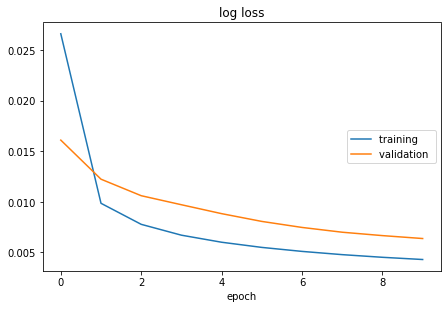

log loss
	training         	 (min:    0.004, max:    0.027, cur:    0.004)
	validation       	 (min:    0.006, max:    0.016, cur:    0.006)

[10/10]    {'log loss': 0.004298747517168522, 'val_log loss': 0.006373116746544838}

Trained.
CPU times: user 5min 18s, sys: 1.67 s, total: 5min 19s
Wall time: 5min 19s


In [9]:
%%time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# number of epochs to train the model
n_epochs = 10
liveloss = PlotLosses()

for epoch_id, epoch in enumerate(range(1, n_epochs+1)):
    # monitor training loss
    logs = {}

    for phase in ['train', 'test']:
        running_loss = 0.0
        for data in dataloaders[phase]:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            images = images.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            if phase == 'train':
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
            
            # update running training loss
            running_loss += loss.detach() * images.size(0)
            
        # print avg training statistics 
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if phase == 'test':
            prefix = 'val_' # that shit is hardcoded in PlotLosses - test called as "validation"
        if phase == 'train':
            prefix = ''     # that one too - "train" will be displayed only if label is empty
        logs[prefix + 'log loss'] = epoch_loss.item()
    liveloss.update(logs)
    liveloss.send()
    print(f"\n[{epoch_id+1}/{n_epochs}]    {logs}")
print("\nTrained.")

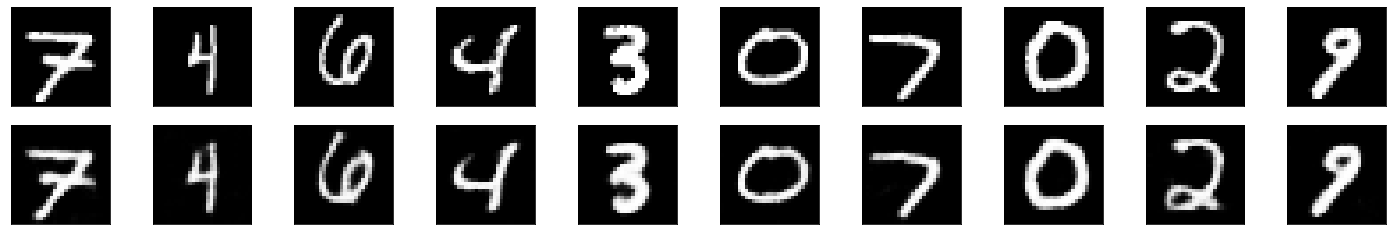

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
dataiter.next()
dataiter.next()
images, labels = dataiter.next()
images = images.to(device)
# get sample outputs
output = model(images)
output = output.cpu()
# prep images for display
images = images.cpu()
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


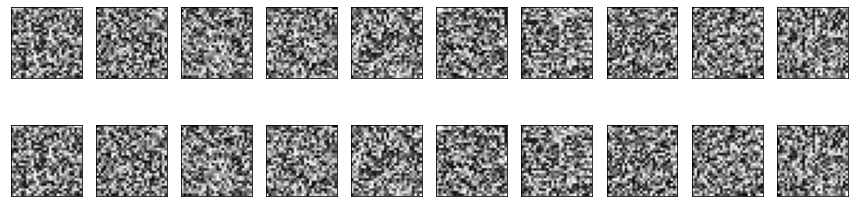

In [11]:
### random input
random_input = np.empty((10, 1, 28, 28))
for j in range(0, 10):
    random_input[j][0] = (np.random.randint(0, 100, (28*28))/100.0).reshape(28, 28)
    
output = model(torch.Tensor(random_input).to(device))
output = output.cpu()
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(15,4))

# input images on top row, reconstructions on bottom
for images, row in zip([random_input, output], axes):
    for img, ax in zip(random_input, row):
        ax.imshow(np.squeeze(img), cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


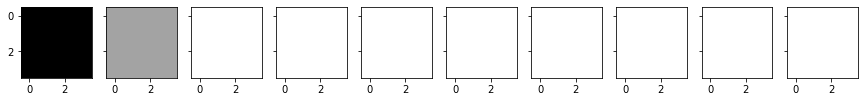

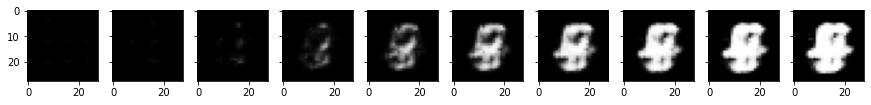

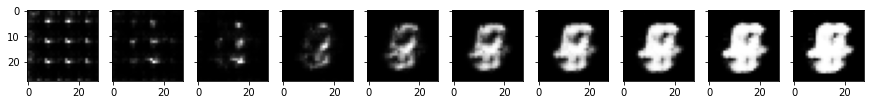

In [12]:
### "diagonal" latent layer
decode_input = np.empty((10, 64, 1, 1))
for j in range(0, 10):
    fill = (j)/10.0
    decode_input[int(j)] = np.full((64, 1, 1), fill)

output = model.decode(torch.Tensor(decode_input).to(device))
output = output.cpu()
output = output.detach().numpy()

decode_images = np.empty((10, 4, 4))
for index, j in enumerate(decode_input):
    decode_images[int(index)] = j.sum(axis=0)/10.0
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(decode_images, axes):
    row.imshow(np.squeeze(images), cmap='gray', vmin=0, vmax=1)

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(output, axes):
    row.imshow(np.squeeze(images), cmap='gray', vmin=0, vmax=1)
        
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(output, axes):
    row.imshow(np.squeeze(images), cmap='gray')

In [13]:
# ### latent: 1 of 16 dimensions filled with 1
# decode_input = np.empty((10, 16, 7, 7))
# for j in range(0, 10):
#     fill = (j)/10.0
#     decode_input[int(j)] = np.full((16, 7, 7), fill)
#     for jj in range(0, 1):
#         decode_input[int(j)][jj] = np.full((7, 7), 1)

# output = model.decode(torch.Tensor(decode_input).to(device))
# output = output.cpu()
# output = output.detach().numpy()

# decode_images = np.empty((10, 7, 7))
# for index, j in enumerate(decode_input):
#     decode_images[int(index)] = j.sum(axis=0)/16.0
    
# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,5))
# # input images on top row, reconstructions on bottom
# for images, row in zip(decode_images, axes):
#     row.imshow(np.squeeze(images), cmap='gray', vmin=0, vmax=1)

# fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,5))
# # input images on top row, reconstructions on bottom
# for images, row in zip(output, axes):
#     row.imshow(np.squeeze(images), cmap='gray', vmin=0, vmax=1)
        
# fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,5))
# # input images on top row, reconstructions on bottom
# for images, row in zip(output, axes):
#     row.imshow(np.squeeze(images), cmap='gray')

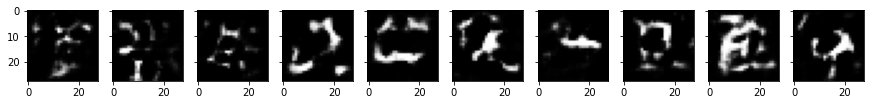

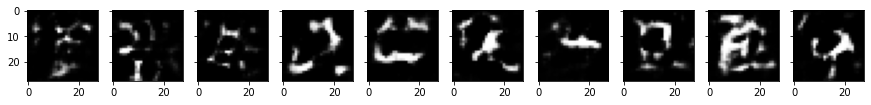

In [14]:
decode_input = np.empty((10, 64, 1, 1))
for j in range(0, 10):
    fill = 0
    decode_input[int(j)] = np.full((64, 1, 1), fill)
    decode_input[j][j][0][0] = 1.0

output = model.decode(torch.Tensor(decode_input).to(device))
output = output.cpu()
output = output.detach().numpy()

#print(decode_input.reshape(10,10))

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(output, axes):
    row.imshow(np.squeeze(images), cmap='gray', vmin=0, vmax=1)
        
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(output, axes):
    row.imshow(np.squeeze(images), cmap='gray')

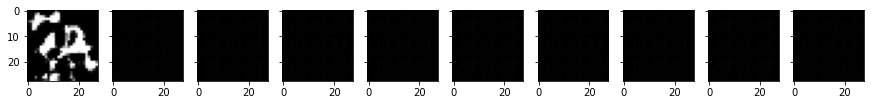

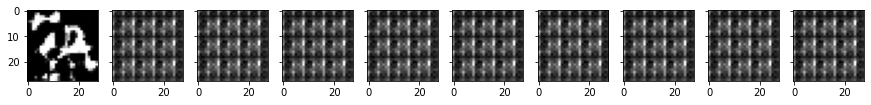

In [15]:
decode_input = np.empty((10, 64, 1, 1))
for j in range(0, 10):
    fill = 0
    decode_input[int(j)] = np.full((64, 1, 1), fill)

decode_input[0][1][0][0] = 1.0
decode_input[0][8][0][0] = 1.0
decode_input[0][9][0][0] = 1.0
    
output = model.decode(torch.Tensor(decode_input).to(device))
output = output.cpu()
output = output.detach().numpy()

#print(decode_input.reshape(10,10))

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(output, axes):
    row.imshow(np.squeeze(images), cmap='gray', vmin=0, vmax=1)
        
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(15,5))
# input images on top row, reconstructions on bottom
for images, row in zip(output, axes):
    row.imshow(np.squeeze(images), cmap='gray')